In [77]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### **Data Preprocessing**

In [15]:
# Load the data
df = pd.read_csv('training.csv')
df.head()

,id,X01,Y01,Z01,X11,Y11,Z11,X21,Y21,Z21,X31,Y31,Z31,X41,Y41,Z41,X51,Y51,Z51,class label
0,1,70.462113,64.877114,-50.105813,82.783836,36.042442,-50.988919,33.129188,84.912840,-31.771170,11.74449894,87.84606776,-25.83095954,60.75981013,6.483995741,-67.55649896,43.11996506,89.36165863,-35.92301308,1
1,2,80.177467,133.621433,-25.956572,75.231644,82.430097,-28.312803,85.638509,1.648577,-86.316682,4.41007393,91.60476078,-9.267397241,59.56926488,-12.81234112,-75.81174195,94.56115084,12.87179349,-87.24250548,3
2,3,94.375668,25.117151,-90.062926,58.594457,90.858450,-35.231873,52.880235,134.362373,-40.889689,79.81444417,20.53839623,-84.86809816,58.64936729,3.19900334,-73.99897842,?,?,?,3
3,4,54.436127,85.347174,24.615378,3.513213,139.637270,34.114724,43.561212,44.735279,-52.898213,66.481943,133.8555292,23.79353568,-35.23368242,125.630729,13.99611649,19.48363818,148.505225,41.92023787,5
4,5,90.675942,64.739737,-56.472013,59.220964,140.970317,-23.333981,-7.020105,96.997434,-1.700752,28.13071821,102.3391386,9.255898442,-32.15985314,70.39580324,-14.58139002,10.47064788,153.7138897,-17.15906812,5


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           30000 non-null  int64  
 1   X01          30000 non-null  float64
 2   Y01          30000 non-null  float64
 3   Z01          30000 non-null  float64
 4   X11          30000 non-null  float64
 5   Y11          30000 non-null  float64
 6   Z11          30000 non-null  float64
 7   X21          30000 non-null  float64
 8   Y21          30000 non-null  float64
 9   Z21          30000 non-null  float64
 10  X31          30000 non-null  object 
 11  Y31          30000 non-null  object 
 12  Z31          30000 non-null  object 
 13  X41          30000 non-null  object 
 14  Y41          30000 non-null  object 
 15  Z41          30000 non-null  object 
 16  X51          30000 non-null  object 
 17  Y51          30000 non-null  object 
 18  Z51          30000 non-null  object 
 19  clas

In [36]:
df['class label'].unique()

array([1, 3, 5, 4, 2])

In [39]:
# Drop the id column
df = df.drop('id', axis=1)

# Replace "?" with 0
df = df.replace('?', 0)

# Convert Column X31 to Z51 into float type
df['X31'] = df['X31'].astype(float)
df['Y31'] = df['Y31'].astype(float)
df['Z31'] = df['Z31'].astype(float)
df['X41'] = df['X41'].astype(float)
df['Y41'] = df['Y41'].astype(float)
df['Z41'] = df['Z41'].astype(float)
df['X51'] = df['X51'].astype(float)
df['Y51'] = df['Y51'].astype(float)
df['Z51'] = df['Z51'].astype(float)

# Minus 1 for the target column
df['class label'] = df['class label'] - 1

# Feature Scaling without the target column
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])

In [11]:
df.head(10)
# df.info()

,X01,Y01,Z01,X11,Y11,Z11,X21,Y21,Z21,X31,Y31,Z31,X41,Y41,Z41,X51,Y51,Z51,class label
0,0.684495,-0.632941,-0.616789,0.981405,-1.215292,-0.642779,-0.455019,0.053144,-0.040703,-1.124328,0.137410,0.113299,0.423857,-1.560114,-1.083016,0.407150,0.293552,-0.398296,1
1,0.981293,1.078481,0.087100,0.748671,-0.065603,0.011064,1.110511,-1.975818,-1.595394,-1.339500,0.226762,0.575950,0.389660,-1.992679,-1.312070,1.903389,-1.197297,-1.862167,3
2,1.415039,-1.622784,-1.781438,0.235966,0.143288,-0.188440,0.133845,1.258117,-0.300605,0.872656,-1.462628,-1.535716,0.363237,-1.633754,-1.261772,-0.847054,-1.448179,0.626396,3
3,0.194912,-0.123329,1.561144,-1.461460,1.352240,1.811099,-0.143995,-0.925892,-0.642880,0.481517,1.231147,1.499402,-2.333436,1.110792,1.179791,-0.280345,1.446309,1.822156,5
4,1.302015,-0.636361,-0.802348,0.255273,1.385279,0.154623,-1.652043,0.347618,0.816383,-0.643602,0.481939,1.093339,-2.245144,-0.127406,0.386863,-0.542500,1.547830,0.136939,5
5,-1.082069,1.222160,-0.405120,-1.600180,0.324847,0.554042,-2.253003,0.900364,-0.438947,-1.575880,1.200393,-0.509983,0.011018,1.152186,-0.377121,-1.990212,0.407678,0.089866,5
6,0.800452,-0.320395,-0.751996,-0.349962,1.531023,0.522264,-0.344197,0.374663,0.700428,0.883087,-0.840358,-0.733794,0.365241,0.416691,0.605957,0.823436,-1.014876,-0.823549,4
7,-0.742676,-0.029832,1.615191,-1.524805,-0.165265,1.724156,0.785788,0.948150,1.638626,0.006613,1.049898,2.158906,0.485177,1.252990,1.950564,0.229236,0.446715,1.411048,2
8,1.799230,-1.662198,-1.680279,-1.346053,-0.092163,-0.452636,0.352949,1.308414,0.028039,1.185464,-1.656870,-1.441695,0.403162,-1.851712,-1.380266,0.620603,0.394261,-0.225100,3
9,-1.597327,-0.194378,-0.758765,-0.581913,-2.058852,0.942499,-0.918522,0.080606,-0.895463,-1.468879,-1.950866,0.834805,-1.321393,-1.705466,0.791447,-0.847054,-1.448179,0.626396,1


In [55]:
# Define a function to do the whole process:
def preprocessing(df):
    df = df.drop('id', axis=1)
    df = df.replace('?', 0)
    df['class label'] = df['class label'] - 1
    df['X31'] = df['X31'].astype(float)
    df['Y31'] = df['Y31'].astype(float)
    df['Z31'] = df['Z31'].astype(float)
    df['X41'] = df['X41'].astype(float)
    df['Y41'] = df['Y41'].astype(float)
    df['Z41'] = df['Z41'].astype(float)
    df['X51'] = df['X51'].astype(float)
    df['Y51'] = df['Y51'].astype(float)
    df['Z51'] = df['Z51'].astype(float)

    scaler = StandardScaler()
    df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])

    # Convert the whole dataframe to tesnor
    X = torch.tensor(df.iloc[:, :-1].values, dtype=torch.float)
    y = torch.tensor(df.iloc[:, -1].values, dtype=torch.float)

    return X, y

In [50]:
# Preprocess the data
training = pd.read_csv('training.csv')
validation = pd.read_csv('validation.csv')

X_train, y_train = preprocessing(training)
X_val, y_val = preprocessing(validation)

In [51]:
# Load the data into DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

### **Model Building**

In [33]:
# Define the model
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(18, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [107]:
# Initialize the model, loss function and optimizer
model = NN().to(device)
loss = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

### **Train the model**

In [101]:
def train(n_epochs, model, loss, optimizer, train_loader, val_loader):
    training_loss = []
    validation_loss = []
    val_accuracy = []

    for epoch in range(1, n_epochs+1):
        model.train()
        train_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss_value = loss(output, target.long())
            loss_value.backward()
            optimizer.step()
            train_loss += loss_value.item()
        train_loss /= len(train_loader)
        training_loss.append(train_loss)

        # Set the model to evaluation mode
        model.eval()
        total = 0
        correct = 0
        val_loss = 0.0
        optimizer.zero_grad()

        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            loss_value = loss(output, target.long())
            val_loss += loss_value.item()

            total += target.size(0)
            correct += (predicted == target).sum().item()

        val_loss /= len(val_loader)
        validation_loss.append(val_loss)

        accuracy = correct / total
        val_accuracy.append(accuracy)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch}, Training Loss: {train_loss}, Validation Loss: {val_loss}, Accuracy of the validation set: {accuracy*100}%')

        # Save the best model
        if epoch == 1:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                torch.save(model.state_dict(), 'best_model.pth')

    return training_loss, validation_loss, val_accuracy

In [108]:
training_loss, validation_loss, val_accuracy = train(n_epochs=50, model=model, loss=loss, optimizer=optimizer, train_loader=train_loader, val_loader=val_loader)

Epoch: 10, Training Loss: 0.8813356034028759, Validation Loss: 0.9436435270461307, Accuracy of the validation set: 64.18%
Epoch: 20, Training Loss: 0.6091387160678408, Validation Loss: 0.6628771137659717, Accuracy of the validation set: 80.17999999999999%
Epoch: 30, Training Loss: 0.5545187255085658, Validation Loss: 0.6155451948096038, Accuracy of the validation set: 82.95%
Epoch: 40, Training Loss: 0.3874196246393454, Validation Loss: 0.4892468815016898, Accuracy of the validation set: 85.39%
Epoch: 50, Training Loss: 0.33434105675611925, Validation Loss: 0.40519017076036734, Accuracy of the validation set: 88.62%


In [109]:
# How to load the best model?
model = NN().to(device)
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

### **Visualize the training loss and validation accuracy**

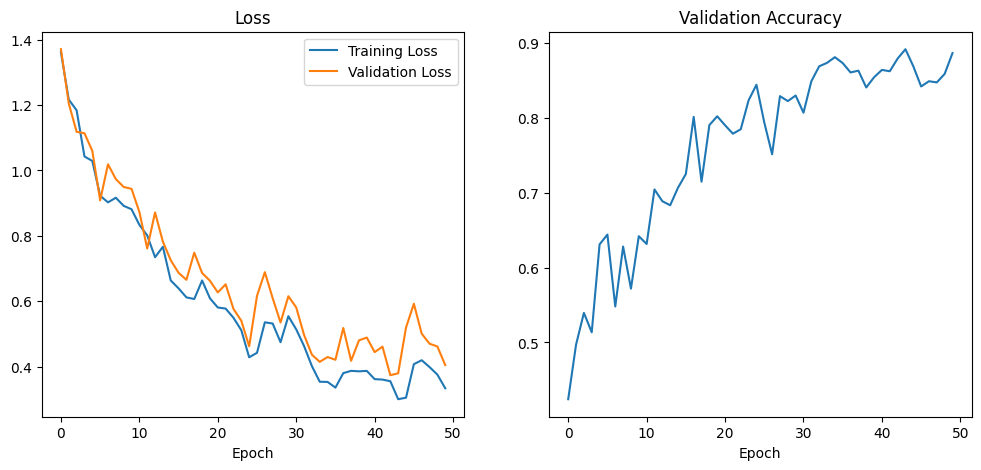

In [111]:
# Plot 2 charts to visualize the training loss and validation accuracy
def plot(training_loss, validation_loss, val_accuracy):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracy)
    plt.xlabel('Epoch')
    plt.title('Validation Accuracy')
    plt.show()

plot(training_loss, validation_loss, val_accuracy)

### **Fine Tuning the Model**


Epoch: 10, Training Loss: 0.40046610592651977, Validation Loss: 0.44371319604907067, Accuracy of the validation set: 83.46000000000001%
Epoch: 20, Training Loss: 0.3146695624600087, Validation Loss: 0.402790593018957, Accuracy of the validation set: 85.05%
Epoch: 30, Training Loss: 0.18134735349907297, Validation Loss: 0.24898544575568218, Accuracy of the validation set: 91.29%
Epoch: 40, Training Loss: 0.13917624131877665, Validation Loss: 0.237511653880215, Accuracy of the validation set: 92.75%
Epoch: 50, Training Loss: 0.09471293847992031, Validation Loss: 0.18068166514917924, Accuracy of the validation set: 94.61%


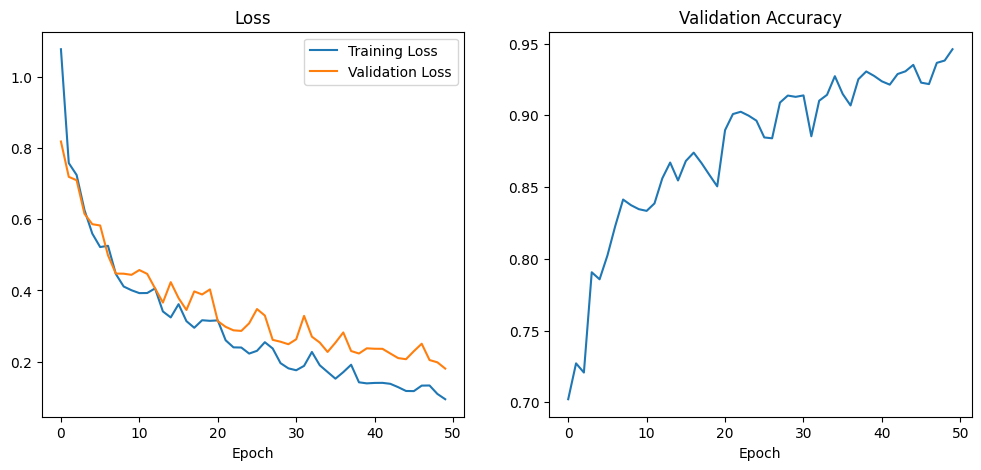

In [113]:
# Increase the batch size to 128/64, change the learning rate to 0.0001
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

model = NN().to(device)
loss = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

training_loss, validation_loss, val_accuracy = train(n_epochs=50, model=model, loss=loss, optimizer=optimizer, train_loader=train_loader, val_loader=val_loader)

plot(training_loss, validation_loss, val_accuracy)